# Single Site Rainfall Model Example

This example demonstrates the basic RWGEN rainfall model workflow using a gauge record at Brize Norton:
 - Initialise a model
 - Preprocess a gauge time series to calculate "reference statistics" 
 - Fit model parameters to reference statistics
 - Simulate one or more stochastic time series
 - Postprocess simulation to calculate/extract relevant statistics

It may be useful to look at the rainfall model overview in the documentation before going through this notebook.

To run a code "cell" in this notebook, click in it and use `Ctrl + Enter`. The cells should be run in order (although it is possible to rerun cells - see options in the `Run` menu). If a cell is still running a `*` will be shown in the square brackets on the left. Towards the bottomleft of the window we will also see that Python is "busy", but it will return to being "idle" once the command has been fully executed.

## Preparation

To prepare for showing our plots within the notebook, we can run the code cell below (which only needs to be done once - effectively boilerplate). Click on the cell below and hit `Ctrl + Enter`.

In [ ]:
from bokeh.io import output_notebook
output_notebook()

## Initialise Model

To get going with the rainfall model, first we need to import the RWGEN package:

In [ ]:
import rwgen

When initialising the rainfall model it is compulsory to specify:
 - Whether the model is for a single site (point) or a spatial model
 - A name for the model (e.g. gauge/site name) for output purposes
 - For a single site model, the path to an input time series file.

The input time series file should be a simple `.csv` file such as:

<div>
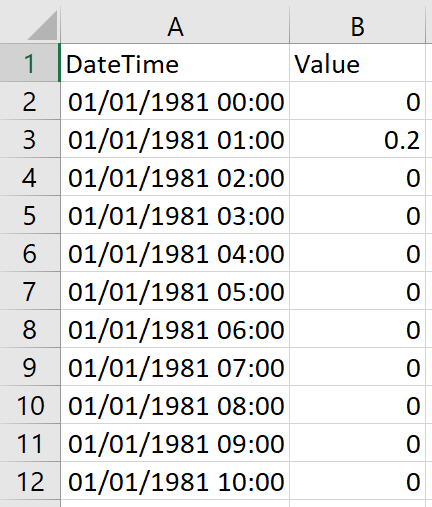
</div>

Dates are specified as day/month/year, i.e. `dd/mm/yyyy hh:mm` or equivalently `'%d/%m/%Y %H:%M'`.

Several additional options can be specified (otherwise defaults will be used), including:
 - Definitions of seasons (default is a monthly model)
 - Probability distribution to use for raincell intensity (default is exponential)
 - Definitions of statistics to use in fitting and/or evaluation (see below)
 - Path to a (root) output folder (default is './output')
 - Metadata for gauges/sites (relevant only to spatial model)

The statistics definitions are some combination of mean, variance, skewness, dry probability and autocorrelation (and spatial cross-correlation for a spatial model) for one or more durations (e.g. 1hr variance, 24hr skewness, etc). These statistics are currently represented in a table, primarily so that user-specified fitting weights can be easily associated with a given statistic. Note that a weight(s) can be set to zero, which means a statistic will be calculated (and available for use in evaluation) but not included in fitting.

Say we do want to override the default statistics definitions, we can provide a path to a `.csv` file that is structured like:

<div>
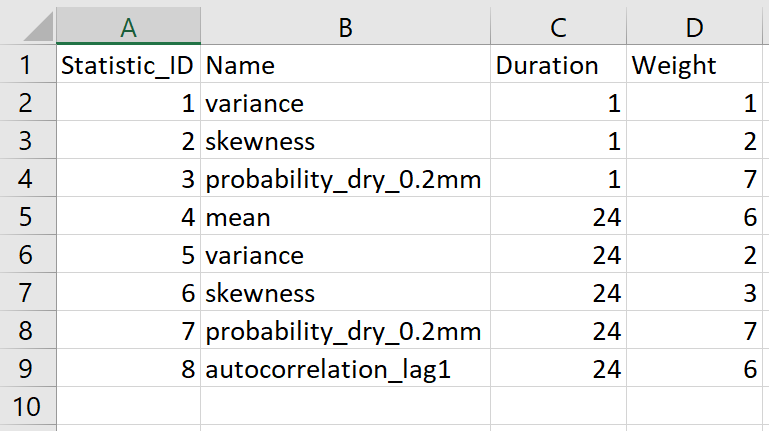
</div>

If we accept defaults for the other options, we initialise the model as follows:

In [ ]:
rainfall_model = rwgen.RainfallModel(
    spatial_model=False,
    project_name='brize_norton',
    input_timeseries='./input/brize_norton.csv',
    statistic_definitions='./input/statistic_definitions.csv',
    intensity_distribution='weibull',
)

Note that:
 - `'./input'` means we have a folder `input` located in the same directory as this notebook. Another path could be specified (use forward slashes or `r` at the beginning of the path "string" - e.g. `'C:/path/to/file.csv'` or `r'C:\path\to\file.csv'`).
 - Single or double quotes is fine for strings in Python.
 - Each argument should be followed by a comma, although they do not have to be on separate lines.

To inspect the attributes we have set explicitly we can do things like:

In [ ]:
rainfall_model.statistic_definitions

## Preprocessing

The goal of preprocessing is to calculate a set of "reference statistics" that can be used in model fitting and/or evaluation (also in simulation for a spatial model). The term "reference" is used instead of "observed" or "gauge" in preparation for e.g. climate change perturbation scenarios.

Options available include:
 - Using a subset of the record period (default is to use full record)
 - Using only months/seasons exceeding a completeness threshold (default is to use all data)
 - Trimming or clipping time series to reduce the influence of outliers (default is not to trim/clip)
 - Annual maxima (AMAX) extraction for a set of durations
 - Output file names (default is reference_statistics.csv - see below)

If we accept the defaults then preprocessing can be conducted using:

In [ ]:
rainfall_model.preprocess()

Running the `preprocess` method calculates a table `reference_statistics`, which is stored as an attribute of `rainfall_model` so that it can be used in subsequent steps. An output file `reference_statistics.csv` is written to the output folder we specified earlier.

The `reference_statistics` attribute or file can be examined manually. A basic plotting option is available via the `plot` method below (by default here plots will open in a new tab).

In [ ]:
rainfall_model.plot()

We could do things like modify the calculated `reference_statistics` before proceeding, but we will leave them as they are at this point.

## Fitting

We can now fit the model parameters using a call to the `fit` method. There are no compulsory arguments here, as the statistics definitions (including weights) and reference statistics have already been set / calculated.

The current default fitting method is season-wise (independent) optimisation using the differential evolution algorithm. This algorithm can make use of some parallelisation, so an option is available for the number of "workers" (cores or logical processors) to use. It should be less than or equal to what is available on the computer, e.g. maximum of 4 for a computer with 4 logical processors. (To run the notebook online, we will stick with one "worker".)

It is also possible to specify bounds for the parameters, as well as to fix particular parameters, which we will see in other examples.

Other approaches for fitting are still under development.

In [ ]:
rainfall_model.fit(
    n_workers=1  # this could be e.g. 4 for a 4-core computer
)

The `fit` method sets the `parameters` attribute of the `rainfall_model` object. It also sets a `fitted_statistics` attribute to keep track of the statistical properties of the Neyman-Scott process. Both of these tables are written to `.csv` files of the same names (unless other file names are specified in the `fit` call). We can use the basic plotting functionality to examine the fit.

In [ ]:
rainfall_model.plot()

## Simulation

We are now ready to do some stochastic simulations. There are several options available here - those relevant to the single site case include:
 - Simulation length (in years)
 - Number of realisations to simulate
 - Length of output timestep (in hours)
 - Calendar (i.e. account for leap years or not - default if yes) and notional start year (default is 2000)
 - Random number seed (optional but can be used for reproducibility)

The output format is currently restricted to `.txt` files without a date/time column to minimise file size.

For example, we can simulate three realisations of 1000 years each at an hourly timestep with:

In [ ]:
rainfall_model.simulate(
    simulation_length=1000,
    n_realisations=3,
    timestep_length=1
)

The command above should write five files to the output folder location specified during model initialisation. These files will be named using the project name (`'brize_norton'` here) and a suffix to indicate the realisation number (`brize_norton_r1.csv, brize_norton_r2.csv, ...`).

## Post-Processing

Post-processing currently works by reading the simulation output files and calculating/extracting statistics for use in analysis and evaluation. By default, the `postprocess` method calculates the same set of statistics defined during model initialisation for checking purposes.

Options are also available to:
 - Extract annual maxima (AMAX) for a set of durations
 - Calculate rainfall depths for a set of durations and return periods

The post-processing currently pools all available realisations for the extraction of AMAX and calculation of depth-duration-frequency (DDF) statistics. The default statistics (mean, variance, etc.) are calculated by breaking the pooled time series into blocks of e.g. 30 (up to 100) years, which provides an indication of variability.

To extract AMAX and to calculate default and DDF statistics, we can use a call like:

In [ ]:
rainfall_model.postprocess(
    amax_durations=[1, 6, 24],  # durations in hours
    ddf_return_periods=[20, 50, 100],  # return periods in years
)

This `postprocess` call uses lists (indicated by square brackets) to specify the required durations and return periods. Unless other output file names are specified, this `postprocess` call will save files called `simulated_statistics.csv, simulated_amax.csv, simulated_ddf.csv`. The annual cycle statistics from the simulations can be plotted:

In [ ]:
rainfall_model.plot()

This is the end of the main exercise.

## Additional Options: Loading a Model

This section demonstrates how to load a model based on files. In particular, it shows how reference statistics and fitted parameter values obtained previously may be loaded directly. Doing this can help us to avoid redoing statistic calculations or fitting, which can be slow. It also means that we can make alterations to values in the files (e.g. in Excel or a text editor) if we want to.

Note that we still have to initialise the model. Currently it is up to the user to ensure that the initialisation arguments are consistent with any files that are subsequently loaded. For example, if loading parameters, we should ensure that the parameters were obtained for a model using the same raincell intensity distribution.

We will load reference statistics based on the gauge record and parameter values. We will also load the fitted (model) statistics associated with the parameters. Running the cell below will replace the previous ``rainfall_model`` created/modified by earlier commands

In [ ]:
import rwgen  # only needed if this command has not been run previously (if it has that is fine)

# Initialise the model
rainfall_model = rwgen.RainfallModel(
    spatial_model=False,
    project_name='brize_norton',
    statistic_definitions='./input/statistic_definitions.csv',
    intensity_distribution='weibull',
    demo_version = True,  # only needed for the demo version/examples
)

# Load reference and fitted (model) statistics from files
rainfall_model.set_statistics(
    reference_statistics='./_loading_example/reference_statistics.csv',
    fitted_statistics='./_loading_example/fitted_statistics.csv',
)

# Set parameter values from file
rainfall_model.set_parameters(
    parameters='./_loading_example/parameters.csv',
)

We could now proceed to do more simulations and post-processing if we want to by running the code cells in the Simulation and Post-Processing sections above.